# Mixture Density Network

구현 참고 
* https://kangbk0120.github.io/articles/2018-05/MDN
* https://medium.com/analytics-vidhya/learning-from-multimodal-target-mixture-density-network-94891d4e357e

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers, metrics
import numpy as np
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import IPython.display as ipd
import time

In [2]:
def generate_data(n_samples):
    epsilon = np.random.normal(size=(n_samples))
    x_data = np.random.uniform(-10.5, 10.5, n_samples)
    y_data = 7*np.sin(0.75*x_data) + 0.5*x_data + epsilon
    return x_data, y_data

n_samples = 1000
y_train, X_train = generate_data(n_samples)

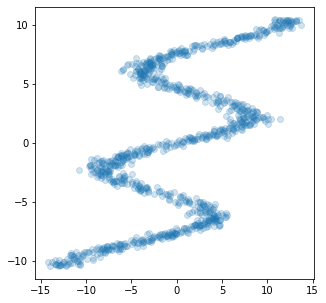

In [3]:
plt.figure(figsize=(5, 5))
plt.scatter(X_train, y_train, alpha=0.2)
plt.show()

In [4]:
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

X_train.shape, y_train.shape

((1000, 1), (1000, 1))

In [5]:
class Unimodal(models.Model):
    def __init__(self):
        super(Unimodal, self).__init__()
        
        self.layer = models.Sequential([
            layers.Dense(16, activation=tf.nn.tanh),
            layers.Dense(1)
        ])
        
    def call(self, x, training=False):
        x = self.layer(x, training=training)
        return x
    
unimodal = Unimodal()
unimodal.build((None, 1))

In [6]:
mse = losses.MeanSquaredError()
adam = optimizers.Adam(learning_rate=1e-3)

In [7]:
EPOCHS = 1000

In [8]:
loss_list = []

for e in range(EPOCHS):
    with tf.GradientTape() as t:
        y_pred = unimodal(X_train)
        loss = mse(y_train, y_pred)
        
    grads = t.gradient(loss, unimodal.trainable_variables)
    adam.apply_gradients(zip(grads, unimodal.trainable_variables))
    
    loss_list.append(loss)
    
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, loss={loss:.8f}")
    
#     plt.figure(figsize=(10, 1))
#     plt.plot(loss_list)
#     plt.show()

1000/1000, loss=23.04677582


In [9]:
y_pred = unimodal(X_train)

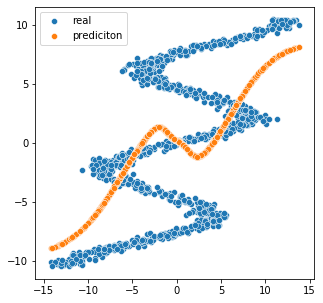

In [10]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=X_train[:, 0], y=y_train[:, 0], label='real')
sns.scatterplot(x=X_train[:, 0], y=y_pred[:, 0], label='prediciton')
plt.legend()
plt.show()

In [11]:
class MDN(models.Model):
    def __init__(self, N=1):
        super(MDN, self).__init__()
        
        self.layer = models.Sequential([
            layers.Dense(16, activation=tf.nn.tanh),
        ])
        
        self.pi = layers.Dense(N, activation=tf.nn.softmax)
        self.mu = layers.Dense(N)
        self.sigma = layers.Dense(N)
        
    def call(self, x, training=False):
        x = self.layer(x, training=training)
        
        pi = self.pi(x)
        mu = self.mu(x)
        sigma = tf.math.exp(self.sigma(x))
        return pi, mu, sigma
    
mdn = MDN(5)
mdn.build((None, 1))

In [12]:
def mdn_loss(y, pi, mu, sigma):
    likelihood = tfp.distributions.Normal(loc=mu, scale=sigma)
    loss = likelihood.prob(y)
    loss = tf.multiply(loss, pi)
    loss = tf.reduce_sum(loss, axis=1, keepdims=True)
    loss = -tf.math.log(loss + 1e-10)
    loss = tf.reduce_mean(loss)
    return loss

In [13]:
EPOCHS = 10000

In [14]:
loss_list = []

for e in range(EPOCHS):
    starttime = time.time()
    with tf.GradientTape() as t:
        pi, mu, sigma = mdn(X_train)
        loss = mdn_loss(y_train, pi, mu, sigma)

    grads = t.gradient(loss, mdn.trainable_variables)
    adam.apply_gradients(zip(grads, mdn.trainable_variables))
    
    loss_list.append(loss)
    
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, loss={loss:.8f}, {time.time()-starttime:.2f} sec/epoch")
    
#     plt.figure(figsize=(10, 1))
#     plt.plot(loss_list)
#     plt.show()

10000/10000, loss=1.27566183, 0.01 sec/epoch


In [15]:
pi, mu, sigma = mdn(X_train)

In [16]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(0, 1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi)

In [17]:
y_pred = list()
rn = np.random.randn(n_samples)

for i,_k in enumerate(k):
    y_pred.append(rn[i] * sigma[i][k[i]].numpy() + mu[i][k[i]].numpy())

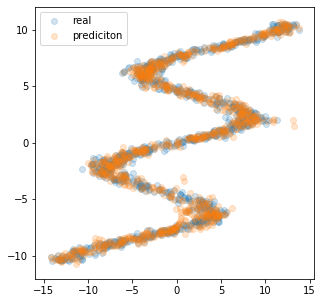

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(x=X_train[:, 0], y=y_train[:, 0], label='real', alpha=.2)
plt.scatter(x=X_train[:, 0], y=y_pred, label='prediciton', alpha=.2)
plt.legend()
plt.show()